# Neuroevolution with GPOL-based framework

In this notebook, we will study the use of GPOL-based Genetic Algorithm implementation for Neuroevolution.


## Environment preparation

### Imports

In [1]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt

from gpolnel.utils.datasets import load_boston
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

from gpolnel.problems.neuroevolution import SMLNN
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.neuroevolution import _feedforward_nn
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import nn_init, ERC, nn_init_individual
from gpolnel.operators.variators import nn_xo, prm_nn_mtn
from gpolnel.operators.selectors import prm_tournament


### Global settings

In [2]:
seed = 1
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'


In [3]:
# Data split
X_train = pd.read_csv('datamart/X_train_clipped_scaled.csv').values
X_test = pd.read_csv('datamart/X_test_clipped_scaled.csv').values
y_train = torch.tensor(pd.read_csv('datamart/y_lactose_train.csv')['lactose_percent'].values)
y_test = torch.tensor(pd.read_csv('datamart/y_lactose_test.csv')['lactose_percent'].values)


In [4]:
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1
total_batches = 1
batch_size = X_train.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_test.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_test.shape[0] + X_test.shape[0]))

# Creates training and validatation data sets
ds_train = TensorDataset(torch.from_numpy(X_train).float().to(device), y_train)
ds_val = TensorDataset(torch.from_numpy(X_test).float().to(device), y_test)

# # Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)

Batch size: 226
Total batches: 1

Train:	226
Val:	98
Test:	98
Total:	422


#### Data scaling

## Step 1: Search space definition

The search space in this example sets the structure of the neural networks:

- `input_shape`: the number of features in the dataset.
- `init_factor`: the multiplication factor to be used for initializing weights.
- `n_hidden_neurons`: the number of neurons in each NN layer. If just one layer is passed, this means
      that there is no hidden layer in the NN. On the other hand, if the *n_hidden_neurons* list has more than one value,
      the second value onwards are the number of neurons in each corresponding hidden layer. Notice that for evolutionary learning,
      the weights in the first layer or in the hidden layers are learned in the same way.
- `activation`: the activation function of each NN layer.
- `n_output`: the number of neurons at output layer.
- `device`: the physical device to be used to handle torch tensors.
- `n_batches`: number of batches to be used for loading data during training.


In [5]:
sspace_nn = {
    'input_shape': X_train.shape[1],
    #
    # NN specifications
    #
    'init_factor': .01,
    'n_hidden_neurons': [1, 2],
    'activation': [torch.relu, torch.relu, None],
    'n_output': 1,
    #
    #
    #
    'n_batches': total_batches,
    'device': device
}


## Step 2: SML Problem instance definition

The problem instance of NN for regression problems in GPOL is a Supervise Machine Learning problem, specified by the specific class `SMLNN`, as in GP. Notice that the attribute of the `SMLNN` object are the same that we specified when setting the object of the parent class `SML`. However, we need different classes for evolving NNs because come methods had to be rewritten.

A SMLNN instance is defined by:

- `sspace`: the search space: the Python dictionary previously defined;
- `ffunction`: the fitness function, which is an Object of the Ffunctions class.
- `dl_train` and `dl_test`: the training and unseen data loaders;
- `n_jobs`: the number of jobs for parallelized operations.


In [6]:
pi_sml = SMLNN(
    sspace=sspace_nn,
    ffunction=Ffunctions('mse'),
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
    n_jobs=8
)


## Step 3: GA instantiation

In [7]:
ps = 226
mutation_step = .5
mutation_prob = .5
xo_prob = .1
selection_pressure = .5
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=nn_init,
    selector=prm_tournament(pressure=selection_pressure),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed,
    #
    # As in the example of using the traditional GSGP with GPOL, for Neuroevolution of the NN hyperparameters,
    # the algorithm is a GA object, and we specify the specific XO and Mutation operators.
    # In this case, however, to handle with NNs.
    #
    crossover=nn_xo,
    mutator=prm_nn_mtn(ms=mutation_step, sspace=sspace_nn)
)


In [8]:
mheuristic._initialize(tree=False)

true tensor([4.8026, 4.8893, 4.8665, 4.8109, 4.9653, 4.8828, 4.9404, 4.8287, 4.9705,
        4.8803, 4.8445, 4.9051, 4.8273, 4.8832, 4.9922, 4.9701, 4.8387, 4.9488,
        4.8752, 4.8391, 5.0049, 4.8925, 4.9491, 4.8631, 5.0085, 4.9025, 4.9186,
        4.8955, 4.8816, 4.9253, 4.8763, 4.9949, 4.9234, 4.8367, 4.9186, 4.9569,
        4.9543, 4.8434, 4.8225, 4.9261, 4.8383, 4.8956, 4.8916, 4.7730, 5.0311,
        4.9831, 4.8391, 4.8264, 4.9182, 4.8349, 4.8317, 4.8658, 4.8277, 5.0098,
        4.8399, 4.8542, 4.8816, 4.9811, 4.8192, 4.9439, 4.9096, 4.8432, 4.8961,
        4.8705, 4.8970, 4.8136, 4.8668, 4.8652, 4.8480, 4.7809, 4.8824, 4.9573,
        4.7657, 4.9275, 4.8118, 4.8838, 4.8493, 4.9367, 4.8353, 4.8242, 4.8808,
        5.0329, 4.9104, 4.9236, 4.8263, 4.8549, 4.8565, 4.8898, 4.9459, 4.8681,
        4.7886, 5.0011, 4.9784, 4.8861, 4.8571, 5.0116, 4.8431, 4.8736, 4.9773,
        4.7960, 4.9707, 4.9555, 4.8009, 4.9086, 4.9649, 4.8916, 4.9767, 4.9602,
        4.8717, 4.9099, 4.9064, 4.8

In [9]:
mheuristic.pop

<br />

The individuals' representation now are NN weights and biases. Both are stored in the `repr_` attribute of the candidate solution. The first element (`repr_[0]`) stores the weights of the NN, and the second element (`repr_[1]`) stores the biases of the NN.


In [10]:
mheuristic.pop.individuals[0]

In [11]:
mheuristic.pop.individuals[0].repr_

[[tensor([[ 0.0066],
          [ 0.0027],
          [ 0.0006],
          [ 0.0062],
          [-0.0045],
          [-0.0017],
          [-0.0152],
          [ 0.0038],
          [-0.0103],
          [-0.0056],
          [-0.0089],
          [-0.0006]]),
  tensor([[-0.0020, -0.0097]]),
  tensor([[0.0042],
          [0.0027]])],
 [tensor([-0.4212]), tensor([-0.5107, -1.5727]), tensor([-0.1232])]]

In [12]:
print(f'\nGP population: {mheuristic.pop.__class__} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

print(f'\nGP best individual {mheuristic.best_sol.repr_}, fitness {mheuristic.best_sol.fit}\n\n')



GP population: <class 'gpolnel.utils.population.Population'> (226 individuals)

Poppulation fitness tensor([5766.0801, 5766.0801, 5766.0801])...
Poppulation valid [True, True, True]...


GP best individual [[tensor([[-0.0024],
        [-0.0058],
        [ 0.0069],
        [-0.0100],
        [-0.0004],
        [-0.0139],
        [-0.0035],
        [ 0.0194],
        [ 0.0042],
        [ 0.0006],
        [-0.0211],
        [ 0.0211]]), tensor([[ 0.0032, -0.0038]]), tensor([[-0.0027],
        [ 0.0048]])], [tensor([-0.3718]), tensor([-1.0149, -0.5294]), tensor([0.3605])]], fitness 5766.080078125




### Solve

In [13]:
# Log settings
file_dir = './log/'
file_name = 'intro_nn.log'
log_path = file_dir + file_name
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

# Learning
n_iter = 5000
mheuristic.solve(
    n_iter,
    verbose=3, log=2, log_path=log_path,
    test_elite=True
)


true tensor([4.9253, 4.8639, 4.9917, 5.0073, 4.8948, 4.8116, 4.8890, 5.0014, 4.8956,
        4.9439, 4.9141, 4.8832, 4.9104, 4.8797, 4.9015, 4.8817, 4.9573, 4.9266,
        4.8391, 4.9602, 4.8273, 4.8260, 4.8273, 4.9086, 4.8615, 4.9126, 4.9563,
        4.8953, 4.8893, 4.8493, 4.7960, 4.9706, 4.9528, 4.8353, 4.8384, 4.8571,
        4.7290, 4.9784, 4.9649, 4.9367, 4.8118, 4.8480, 4.7657, 4.9811, 5.0329,
        4.8432, 4.9293, 4.8961, 4.8349, 4.8399, 4.8225, 4.8186, 4.9186, 4.8473,
        5.0116, 4.9488, 5.0441, 4.8824, 4.8936, 5.0020, 4.9186, 4.8752, 4.7225,
        4.9491, 4.9949, 4.8916, 4.7730, 4.7613, 4.8183, 4.8434, 4.9653, 4.9728,
        4.8717, 4.8277, 5.0311, 4.8828, 5.0203, 4.8632, 4.8192, 4.9459, 4.8946,
        4.7435, 4.9922, 4.8942, 4.9980, 4.8681, 4.8317, 4.8587, 4.9800, 4.8705,
        4.9313, 4.9138, 4.8736, 4.8494, 4.8322, 4.8808, 4.9096, 4.9049, 4.9195,
        4.8856, 4.7408, 4.8741, 4.9196, 4.8891, 4.8970, 4.8456, 4.9051, 4.8672,
        4.8242, 4.9261, 4.9024, 4.8

KeyboardInterrupt: 

### GP evolution

In [ ]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Val fitness history
history_val_fits = [float(row[8].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [int(row[6]) for row in rows]

# Runtime
history_timing = [float(row[5]) for row in rows]


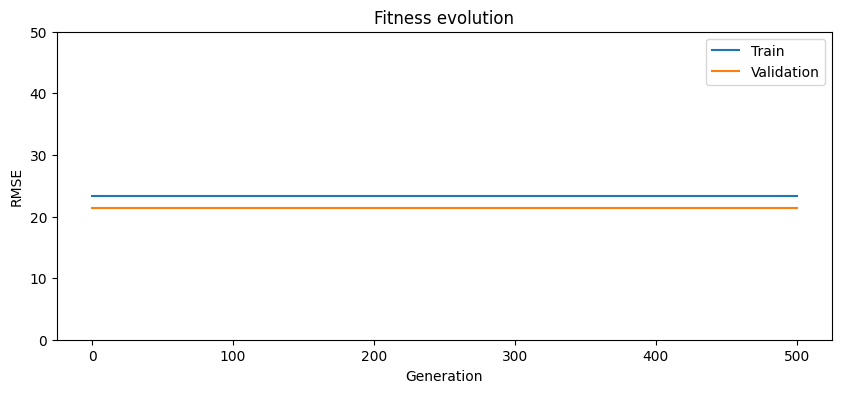

Best solution RMSE fitness: 23.30 train, 21.32 validation.



In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_fits, label='Train')
plt.plot(history_val_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0, top=50)
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} validation.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))


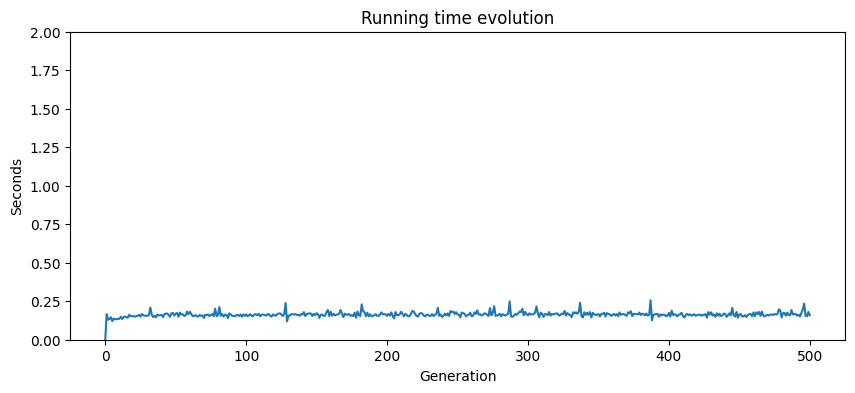

Total time: 1.37 minutes.



In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0, top=2)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))


In [ ]:
# Weitghs
mheuristic.best_sol.repr_[0]

[tensor([[ 1.8426e-03,  8.3526e-03,  4.7077e-03, -1.6549e-02],
         [-2.7163e-03,  4.2586e-03, -2.0060e-04, -1.1914e-02],
         [ 3.9790e-03,  1.4502e-05,  7.8847e-03,  8.9951e-03],
         [-6.2597e-03, -5.9812e-04,  1.0688e-02, -1.0690e-02],
         [-1.0768e-02,  3.5516e-03, -1.1065e-02,  4.3933e-03],
         [-6.9039e-03,  2.8350e-02, -1.9123e-03,  5.7695e-04],
         [-4.6060e-03, -4.2151e-03,  1.6138e-03,  3.3939e-03],
         [ 1.3757e-02,  8.5126e-03, -3.0014e-04, -5.9552e-04],
         [ 1.8269e-02, -5.7760e-03, -7.7697e-03,  1.1308e-02],
         [ 1.6889e-02,  5.6309e-03, -1.8265e-02, -1.0899e-03],
         [ 9.1779e-03,  3.3012e-03,  8.1155e-03,  1.2981e-03],
         [ 1.3729e-02,  1.4613e-02,  5.7391e-03,  9.5478e-03],
         [-1.1205e-02,  1.5109e-02, -5.1435e-03, -1.9587e-03]]),
 tensor([[ 0.0009, -0.0045, -0.0138,  0.0043,  0.0021],
         [ 0.0084,  0.0054,  0.0035,  0.0008,  0.0041],
         [-0.0041, -0.0011, -0.0255,  0.0044, -0.0097],
         [ 

In [ ]:
# Bias
mheuristic.best_sol.repr_[1]

[tensor([ 0.6839, -0.5889,  1.1439, -0.4621]),
 tensor([ 0.5171, -1.3991,  0.4515,  0.1343, -0.3464]),
 tensor([2.4133])]

<br />

> ##### **Exercise for extra points**
**Implement a crossover and a mutation operators for evolving the weights and bias of a Neural Network.**

<br />